### Description
Case 1 refers to the case where there is no change in onboarding, even after DDO is implemented. This is one extreme of what could happen as a result of DDO being implemented.

In this case, we expect the following to occur:
1. The assumption of this scenario is that everything else is held constant. This means that there is more block space available than demand, and will result in `base_fee` going to 0.
2. This means that the only protocol revenue will be from the following sources: a) `penalty_fee`, b) `batch_fee`, c) `overestimation_fee`.
3. This will result in the same locking as before, since onboarding is assumed to be the same, but circulating supply will increase due to reduced burn.  Thus, we would expect a difference in the status-quo and Case-1 in the following metrics: a) `CirculatingSupply`, b) `Locked/CirculatingSupply`

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy

import numpy as np
import pandas as pd
import sqlalchemy as sqa

from jax.random import PRNGKey
import jax.numpy as jnp
from jax import random

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, log_likelihood

import pystarboard.data_spacescope as data_spacescope
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.date_utils as date_utils
import mechafil.data as d
import mechafil.data_spacescope as dss
import scenario_generator.utils as u
import cel_utils.disk_utils as du

In [3]:
save_dir = os.path.join(os.environ['HOME'], 'Documents', 'direct_filp_v2')
offline_dir = os.path.join(save_dir, 'offline')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_dir, exist_ok=True)

### Step 1 - Establish baseline for Circulating Supply

In [24]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
lock_target = 0.3
forecast_length = 365*3
sector_duration = 540

current_date = date.today() - timedelta(days=3)
mo = current_date.month - 2  # get 2 mo historical data to get better estimate of gas burn
if mo == 0: mo = 1
start_date = date(current_date.year, mo, 1)
end_date = current_date + timedelta(days=forecast_length)

print(start_date, current_date, end_date)

2023-08-01 2023-10-20 2026-10-19


In [25]:
@du.cache_data(offline_dir)
def get_offline_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date+timedelta(days=1))
    
    return {
        'offline_data': offline_data,
        't_hist_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_hist_rr': t_hist_rr,
        'hist_rr': hist_rr,
        't_hist_fpr': t_hist_fpr,
        'hist_fpr': hist_fpr
    }

od = get_offline_data()
locals().update(od)

In [26]:
smooth_historical_rbp = np.median(hist_rbp[-90:])
smooth_historical_rr = np.median(hist_rr[-90:])
smooth_historical_fpr = np.median(hist_fpr[-90:])

print(smooth_historical_rbp, smooth_historical_rr, smooth_historical_fpr)

5.5471343994140625 0.6116335191287028 0.8569990031735895


In [27]:
rbp = jnp.ones(forecast_length) * smooth_historical_rbp
rr = jnp.ones(forecast_length) * smooth_historical_rr
fpr = jnp.ones(forecast_length) * smooth_historical_fpr

simulation_results = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data
)

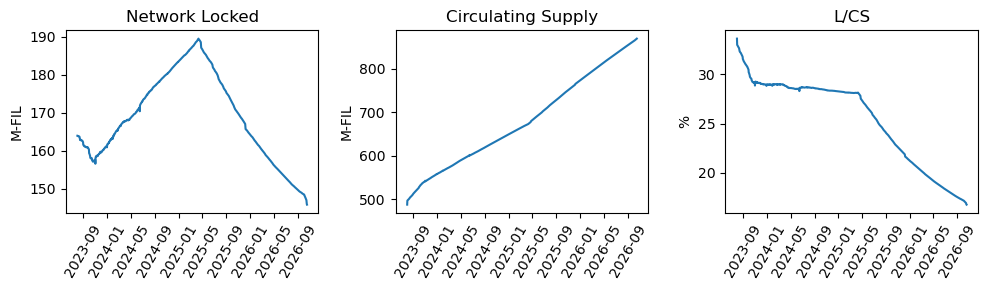

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3))

t = date_utils.get_t(start_date, end_date=end_date)

axx = ax[0]
axx.plot(t, simulation_results['network_locked']/1e6)
axx.set_title('Network Locked')
axx.set_ylabel('M-FIL')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1]
axx.plot(t, simulation_results['circ_supply']/1e6)
axx.set_title('Circulating Supply')
axx.set_ylabel('M-FIL')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[2]
axx.plot(t, simulation_results['network_locked']/simulation_results['circ_supply'] * 100)
axx.set_title('L/CS')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.tight_layout()

### Step 2 - Update gas_burn to simulate base_fee --> 0

In [29]:
# In this case, gas_burn is from sources other than base_fee burn
# get the historical data and use it to make a forecast on gas_burn, by extending median values of historical data
# NOTE: the forecasting complexity could be increased.

sso = data_spacescope.SpacescopeDataConnection(token)
lookback_days = 180
sd = current_date - timedelta(days=lookback_days)
network_fee_breakdown_df = sso.spacescope_query(sd, current_date, 
                     'https://api.spacescope.io/v2/gas/daily_network_fee_breakdown?end_date=%s&start_date=%s')

In [30]:
network_fee_breakdown_df

,stat_date,base_fee_burn,overestimation_burn,precommit_batch_fee_burn,provecommit_batch_fee_burn,penalty_fee_burn,miner_tip
0,2023-04-23T00:00:00Z,12184.438819,1283.940441,205.005719,295.861460,2771.501971,4846.239528
1,2023-04-24T00:00:00Z,12722.786847,1559.948006,136.470541,154.592389,2102.561875,2740.913931
2,2023-04-25T00:00:00Z,14984.098955,1778.190497,167.833540,262.547004,3453.968950,3493.941916
3,2023-04-26T00:00:00Z,1968.123727,214.969081,29.875783,54.328570,3963.776371,3074.283552
4,2023-04-27T00:00:00Z,296.561701,24.737545,25.701719,78.707406,1413.258320,1107.607203
...,...,...,...,...,...,...,...
176,2023-10-16T00:00:00Z,0.004533,0.000315,0.000000,18.487490,11181.133601,10.246533
177,2023-10-17T00:00:00Z,0.004028,0.000260,0.000000,58.420467,33884.684184,10.964621
178,2023-10-18T00:00:00Z,0.006979,0.000549,0.000000,41.978927,1257.757410,11.914248
179,2023-10-19T00:00:00Z,0.039597,0.003064,0.000000,50.532472,967.279886,15.525253


In [31]:
# get a baseline burn forecast
other_burns = ['overestimation_burn', 'precommit_batch_fee_burn', 'provecommit_batch_fee_burn', 'penalty_fee_burn', 'miner_tip']
all_burn_cols = ['overestimation_burn', 'precommit_batch_fee_burn', 'provecommit_batch_fee_burn', 'penalty_fee_burn', 'miner_tip', 'base_fee_burn']
burn_without_basefee = network_fee_breakdown_df[other_burns].sum(axis=1).values
full_burn = network_fee_breakdown_df[all_burn_cols].sum(axis=1).values
median_burn_pct_notbasefee = np.median(burn_without_basefee/full_burn)
print(median_burn_pct_notbasefee)

0.36657503936049785


In [32]:
offline_data_updated_gas_burn = copy.deepcopy(offline_data)
gas_burn_forecast = np.ones(forecast_length)*offline_data['daily_burnt_fil']*median_burn_pct_notbasefee
burnt_fil_vec = np.concatenate([offline_data_updated_gas_burn['burnt_fil_vec'][1:], gas_burn_forecast])
offline_data_updated_gas_burn['burnt_fil_vec'] = burnt_fil_vec

In [33]:
rbp = jnp.ones(forecast_length) * smooth_historical_rbp
rr = jnp.ones(forecast_length) * smooth_historical_rr
fpr = jnp.ones(forecast_length) * smooth_historical_fpr

simulation_results_updated_gasburn = sim.run_sim(
    rbp,
    rr,
    fpr,
    lock_target,

    start_date,
    current_date,
    forecast_length,
    sector_duration,
    offline_data_updated_gas_burn
)

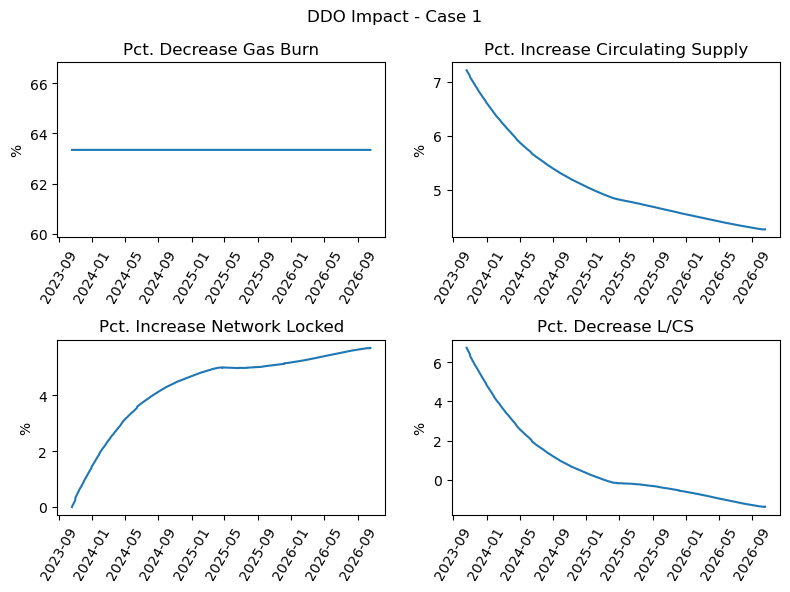

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

t = date_utils.get_t(current_date, end_date=end_date)
offset = (current_date-start_date).days

axx = ax[0,0]
status_quo_burn_fil_vec = np.ones(forecast_length)*offline_data['daily_burnt_fil']
x = gas_burn_forecast
y = status_quo_burn_fil_vec
axx.plot(t, (y-x)/y*100)
axx.set_ylabel('%')
axx.set_title('Pct. Decrease Gas Burn')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[0,1]
x = simulation_results['circ_supply'][offset:]
y = simulation_results_updated_gasburn['circ_supply'][offset:]
axx.plot(t, (y-x)/x*100)
axx.set_title(r'Pct. Increase Circulating Supply')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1,0]
x = simulation_results['network_locked'][offset:]
y = simulation_results_updated_gasburn['network_locked'][offset:]
axx.plot(t, (y-x)/x*100)
axx.set_title(r'Pct. Increase Network Locked')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[1,1]
x = simulation_results['network_locked'][offset:]/simulation_results['circ_supply'][offset:]
y = simulation_results_updated_gasburn['network_locked'][offset:]/simulation_results_updated_gasburn['circ_supply'][offset:]
axx.plot(t, (x-y)/x*100)
axx.set_title(r'Pct. Decrease L/CS')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.suptitle('DDO Impact - Case 1')
plt.tight_layout()